In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing , Holt , ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import r2_score

#    (01)  Simple moving average    

In [ ]:
##############   Code  ##################

''' 
### returns a rolling object
rolling_window = df['GOOG'].rolling(window_size)

## returns a series/dataframe of rolling means
# can also calculate min,max,sum , var , etc ...
rolloing_window.mean()


## multi dimensional
covariance = df[['var1','var2']].rolling(50).var()

'''

In [7]:
close = pd.read_csv('../Datasets/sp500_close (1).csv' , index_col=0 , parse_dates=True)
goog = close[['GOOG']].copy().dropna()
goog.head()

,GOOG
2014-03-27,558.46
2014-03-28,559.99
2014-03-31,556.97
2014-04-01,567.16
2014-04-02,567.00


<Axes: >

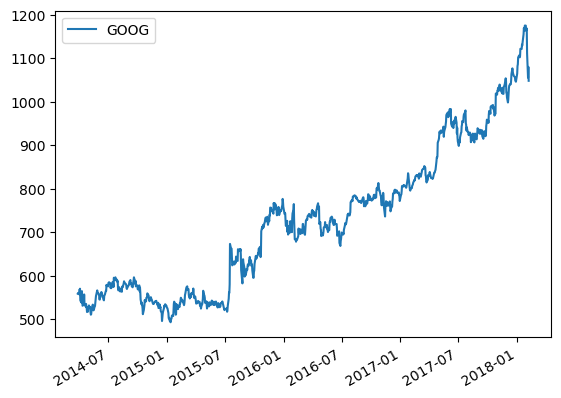

In [8]:
goog.plot()

<Axes: >

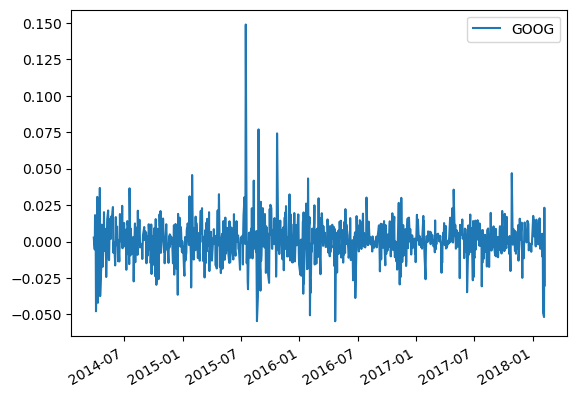

In [10]:
goog_ret = np.log(goog.pct_change(1) +1)
goog_ret.plot()

<Axes: >

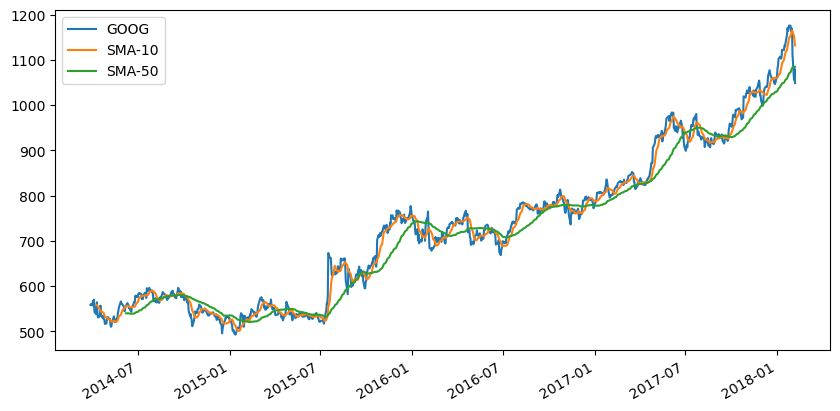

In [13]:
goog['SMA-10'] = goog['GOOG'].rolling(10).mean()
goog['SMA-50'] = goog['GOOG'].rolling(50).mean()
goog.plot(figsize=(10,5))

In [15]:
goog_aapl = close[['GOOG','AAPL']].copy().dropna()
cov = goog_aapl.rolling(50).cov()
cov

GOOG       AAPL
2014-03-27 GOOG          NaN        NaN
           AAPL          NaN        NaN
2014-03-28 GOOG          NaN        NaN
           AAPL          NaN        NaN
2014-03-31 GOOG          NaN        NaN
...                      ...        ...
2018-02-05 AAPL    34.825709  17.568865
2018-02-06 GOOG  2691.756465  38.174468
           AAPL    38.174468  19.121371
2018-02-07 GOOG  2678.778214  49.980378
           AAPL    49.980378  22.052882

[1950 rows x 2 columns]

In [16]:
cov.loc['2018-02-07'].to_numpy()

array([[2678.77821424,   49.98037849],
       [  49.98037849,   22.05288249]])

In [17]:
goog_aapl_ret = np.log(1+ goog_aapl.pct_change(1))
goog_aapl_ret.head()

,GOOG,AAPL
2014-03-27,NaN,NaN
2014-03-28,0.002736,-0.001117
2014-03-31,-0.005408,-0.000223
2014-04-01,0.018130,0.009106
2014-04-02,-0.000282,0.001661


In [18]:
goog_aapl_ret['GOOG-SMA-50'] = goog_aapl_ret['GOOG'].rolling(50).mean()
goog_aapl_ret['AAPL-SMA-50'] = goog_aapl_ret['AAPL'].rolling(50).mean()

<Axes: >

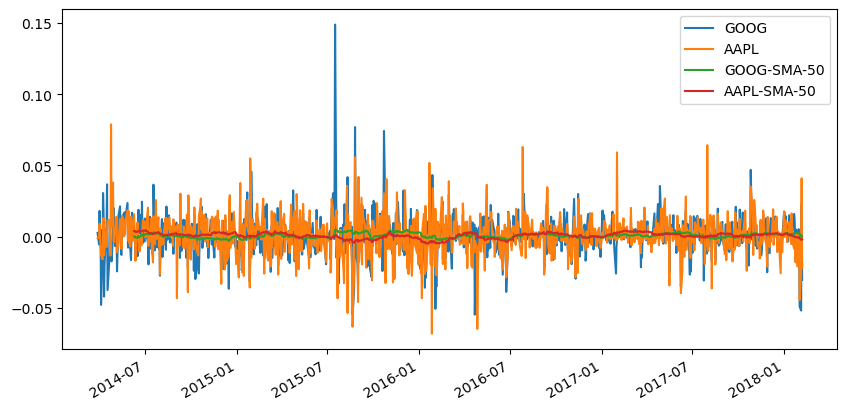

In [20]:
goog_aapl_ret.plot(figsize=(10,5))

# (02) Exponentially-Weighted Moving Average (EWMA)

In [ ]:
''' #######  code #######
xhat = df['var'].ewm(alpha).mean()  # also we can use var , cov , etc...

'''

In [23]:
df = pd.read_csv( '../Datasets/airline_passengers (5).csv',index_col='Month',parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

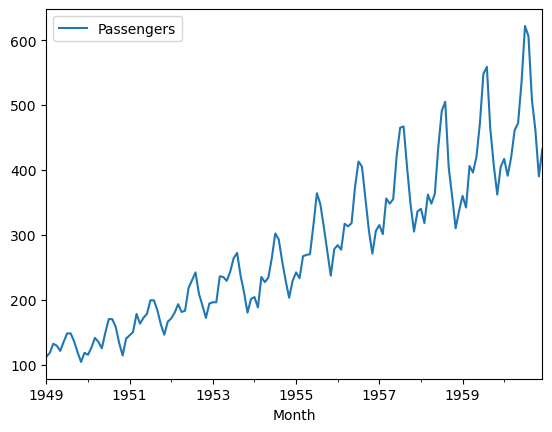

In [24]:
df.plot()

In [25]:
alpha = 0.2
df['EWMA'] = df['Passengers'].ewm(alpha=alpha,adjust=False).mean()  #adjust= True :  then this will calculate something else that we dont want 

# why .mean()  : because we want exponentially weighted mean

<Axes: xlabel='Month'>

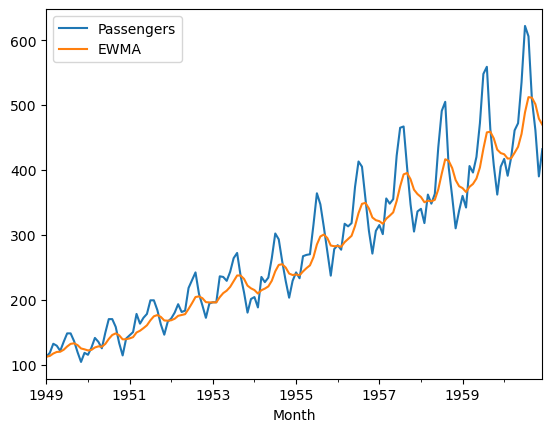

In [26]:
df.plot()

# (03) Simple exponential smoothing 


In [21]:
'''
##########  Code  #############

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

### make the model (data is univariate )
ses = SimpleExpSmoothing(data)

#### 'fit' the model (returns a HoltWintersResult object)
result = ses.fit(smoothing_level=alpha , optimized=False)


##### in-sample prediction or out-of-sample forecast
result.predict(start=start_date ,end=end_date)


##### get all in-sample predictions
result.fittedvalues()

##### forecast n steps ahead
result.forecast(n)

'''

In [30]:
ses = SimpleExpSmoothing(df['Passengers'])
df.index
df.index.freq = 'MS'

c:\Users\Tharindu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
ses = SimpleExpSmoothing(df['Passengers'],initialization_method='legacy-heuristic')
# legacy-heuristic : Just give the sameoutput as above but without that warning
res = ses.fit(smoothing_level=alpha,optimized=False)  

<Axes: xlabel='Month'>

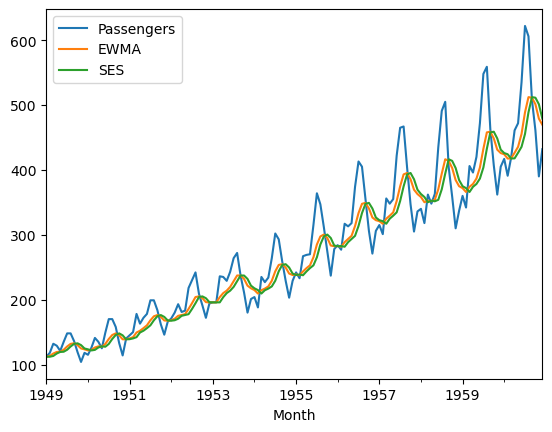

In [37]:
df['SES'] = res.predict(start=df.index[0],end=df.index[-1])
df.plot()

<Axes: xlabel='Month'>

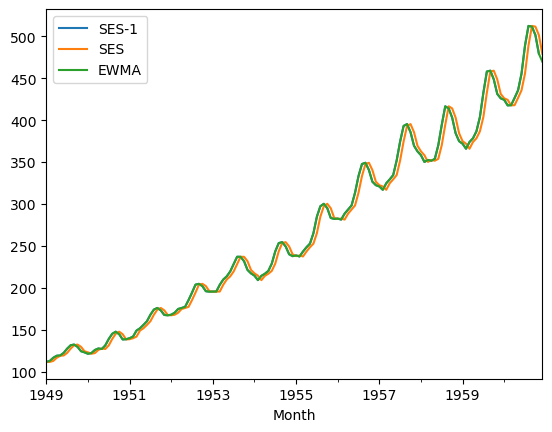

In [39]:
df['SES-1'] = df['SES'].shift(-1)
df[['SES-1','SES','EWMA']].plot()

<Axes: xlabel='Month'>

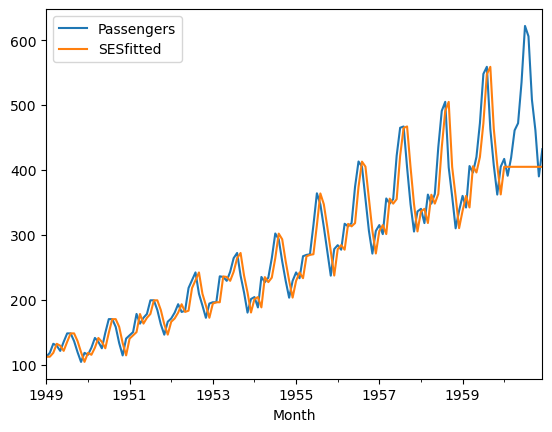

In [45]:
###########  Now lets do a forecast #############
N_test = 12
train = df.iloc[: -N_test]
test = df.iloc[-N_test:]

ses = SimpleExpSmoothing(train['Passengers'] , initialization_method='legacy-heuristic')
res = ses.fit()


# create a boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

df.loc[train_idx , 'SESfitted'] = res.fittedvalues
df.loc[test_idx,'SESfitted'] = res.forecast(N_test)
df[['Passengers','SESfitted']].plot()



In [47]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# (04) Holt's Linear Trend Model 

In [ ]:
'''
#########   code #######

from statsmodels.tsa.holtwinters import Holt

### make the model (data is univariate)
model = Holt(data)

### 'fit' the model (returns a HoltWIntersResults) object
result = model.fit()

## in-simple prediction or out-of-samplt forecast
result.fittedvalues()
result.forecast(n)

'''

<Axes: xlabel='Month'>

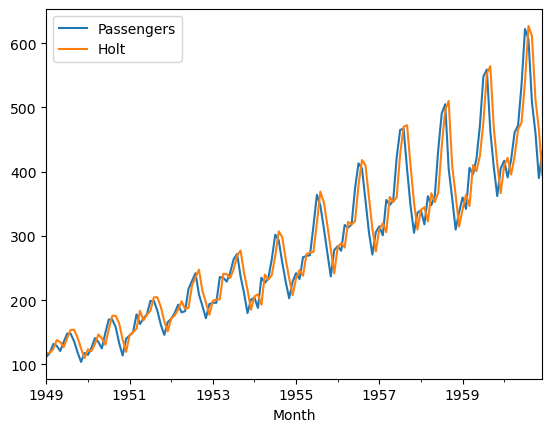

In [50]:
holt = Holt(df['Passengers'],initialization_method='legacy-heuristic')
res_h = holt.fit()
df['Holt'] = res_h.fittedvalues
df[['Passengers','Holt']].plot()

In [51]:
holt = Holt(train['Passengers'] , initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx,'Holt'] = res_h.fittedvalues

<Axes: xlabel='Month'>

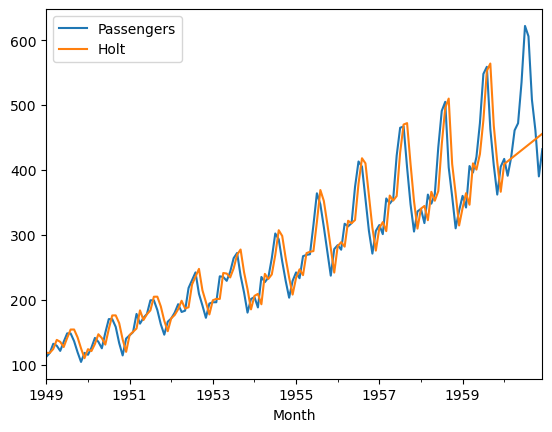

In [52]:
df.loc[test_idx,'Holt'] = res_h.forecast(N_test)
df[['Passengers','Holt']].plot()

# (05)  Holt Winters 

In [ ]:
''' 
######## code #############

from statsmodels.tsa.holtwinters import ExponentialSmoothing

## make the model (data is univariate)
## trend/seasonal args can be 'add' or 'mul'
model = ExponentialSmoothing(data,trend='add',seasonal='add',seasonal_periods=12)

## 'fit' the model
result = model.fit

### in sample prediction or out-of-sample forecast 
result.fittedvalues
result.forecast(n)

'''

<Axes: xlabel='Month'>

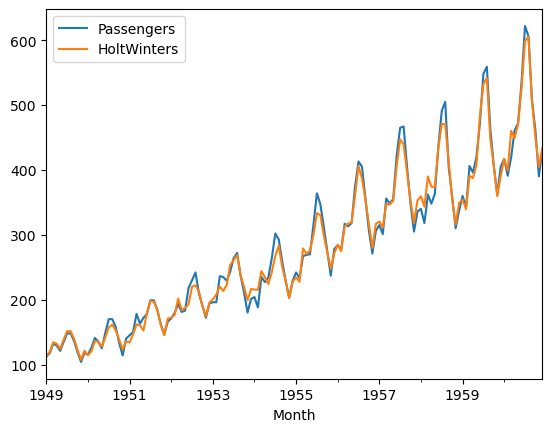

In [55]:
hw = ExponentialSmoothing(train['Passengers'],initialization_method='legacy-heuristic',
                            trend='add' , seasonal='add' , seasonal_periods=12
                            )     
res_hw = hw.fit()

df.loc[train_idx , 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx , 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot()

In [59]:
def rmse(y,t):
       return np.sqrt(np.mean((y-t)**2))

def mae(y,t):
       return np.mean(np.abs(y-t))

print(rmse(train['Passengers'],res_hw.fittedvalues))
print(rmse(test['Passengers'],res_hw.forecast(N_test)))
print(mae(train['Passengers'],res_hw.fittedvalues))
print(mae(test['Passengers'],res_hw.forecast(N_test)))

11.85299098495317
15.543040671839746
8.892027859335215
10.437833883857872


<Axes: xlabel='Month'>

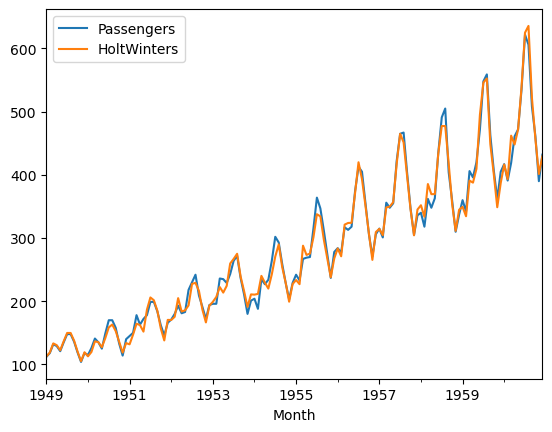

In [60]:
hw = ExponentialSmoothing(train['Passengers'],initialization_method='legacy-heuristic',
                            trend='add' , seasonal='mul' , seasonal_periods=12
                            )     
res_hw = hw.fit()

df.loc[train_idx , 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx , 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot()

In [61]:
print(rmse(train['Passengers'],res_hw.fittedvalues))
print(rmse(test['Passengers'],res_hw.forecast(N_test)))
print(mae(train['Passengers'],res_hw.fittedvalues))
print(mae(test['Passengers'],res_hw.forecast(N_test)))

10.153934838980362
16.53521352526533
7.552052488307954
10.68334189438329


<Axes: xlabel='Month'>

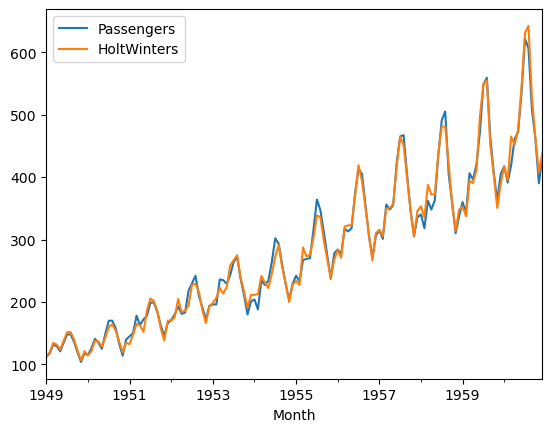

In [62]:
hw = ExponentialSmoothing(train['Passengers'],initialization_method='legacy-heuristic',
                            trend='mul' , seasonal='mul' , seasonal_periods=12
                            )     
res_hw = hw.fit()

df.loc[train_idx , 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx , 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers','HoltWinters']].plot()

In [63]:
print(rmse(train['Passengers'],res_hw.fittedvalues))
print(rmse(test['Passengers'],res_hw.forecast(N_test)))
print(mae(train['Passengers'],res_hw.fittedvalues))
print(mae(test['Passengers'],res_hw.forecast(N_test)))

9.887178133885527
19.102102837542144
7.408706905731018
13.450528282526767


# (06) Walk-Forward Validation 

In [74]:
df = pd.read_csv( '../Datasets/airline_passengers (5).csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'


### Assume the forecast horizon we care about is 12
### Validate over 10 steps 
h=12
steps = 10
Ntest = len(df) -h - steps +1 


### Configuration of hyperparameters
trend_type_list = ['add','mul']
seasonal_type_list = ['add','mul']
damped_trend_list = [True,False]
init_method_list = ['heuristic','legacy-heuristic']
use_boxcox_list = [True , False , 0]

def walkforward(trend_type , seasonal_type,damped_trend,init_method,use_boxcox):
       ## store errors 
       errors =[]
       seen_last = False
       steps_completed = 0

       for end_of_train in range(Ntest,len(df)-h+1):
              train = df.iloc[:end_of_train]
              test = df.iloc[end_of_train:end_of_train + h]

              if test.index[-1] == df.index[-1]:
                     seen_last = True

              steps_completed += 1

              hw = ExponentialSmoothing(
                     train['Passengers'],
                     initialization_method = init_method,
                     trend = trend_type,
                     damped_trend = damped_trend,
                     seasonal = seasonal_type,
                     seasonal_periods = 12,
                     use_boxcox = use_boxcox
              
              )

              res_hw = hw.fit()


              ###### Compute errors for the horizon
              fcast = res_hw.forecast(h)
              error = mean_squared_error(test['Passengers'],fcast)
              errors.append(error)


              return np.mean(errors)

In [75]:
##### test our function 
walkforward('add','add',False,'legacy-heuristic',0)

1812.9387412844524

In [78]:
######### Iterate through all possible options (grid search)
tuple_of_options_lists = (trend_type_list,seasonal_type_list,damped_trend_list,init_method_list,use_boxcox_list)

for x in itertools.product(*tuple_of_options_lists):
       print(x)

('add', 'add', True, 'heuristic', True)
('add', 'add', True, 'heuristic', False)
('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
('add', 'add', False, 'heuristic', True)
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)
('add', 'mul', True, 'heuristic', 0)
('add', 'mul', True, 'legacy-heuristic', True)
('add', 'mul', True, 'legacy-heuristic', False)
('add', 'mul', True, 'legacy-heuristic', 0)
('add', 'mul', False, 'heuristic', True)
('add', 'mul', False, 'heuristic', False)
('add', 'mul', False, 'heuristic', 0)
('add', 'mul', False, 'legacy-heuristic', True)
('add', 'mul', False, 'legacy-heuristic', False)
('add

In [81]:
##### Get the best score #####
best_score = float('inf')
best_option = None
for x in itertools.product(*tuple_of_options_lists):
       score = walkforward(*x)

       if score < best_score:
              print(score)
              best_score = score
              best_options = x


347.9381299036582
293.59393347532176
274.876315425375
239.02433047367472
234.9760353298706
213.24900270826296
189.5829247971459
186.27824065478148
185.66925641247755
185.0149840572324


In [82]:
best_score

185.0149840572324

#  APPLICATIONS 

In [85]:
#################   Sales Data  ####################

df = pd.read_csv("../Datasets/perrin-freres-monthly-champagne (1).csv" , index_col='Month',skipfooter=2,parse_dates=True)

C:\Users\Tharindu\AppData\Local\Temp\ipykernel_156352\1731623642.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("../Datasets/perrin-freres-monthly-champagne (1).csv" , index_col='Month',skipfooter=2,parse_dates=True)


<Axes: xlabel='Month'>

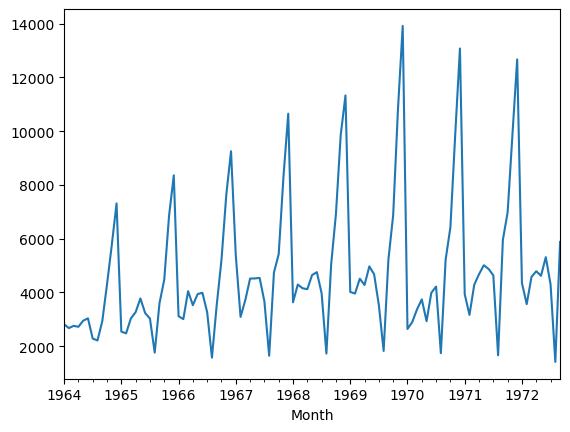

In [86]:
df.columns = ['Sales']
df['Sales'].plot()

<Axes: xlabel='Month'>

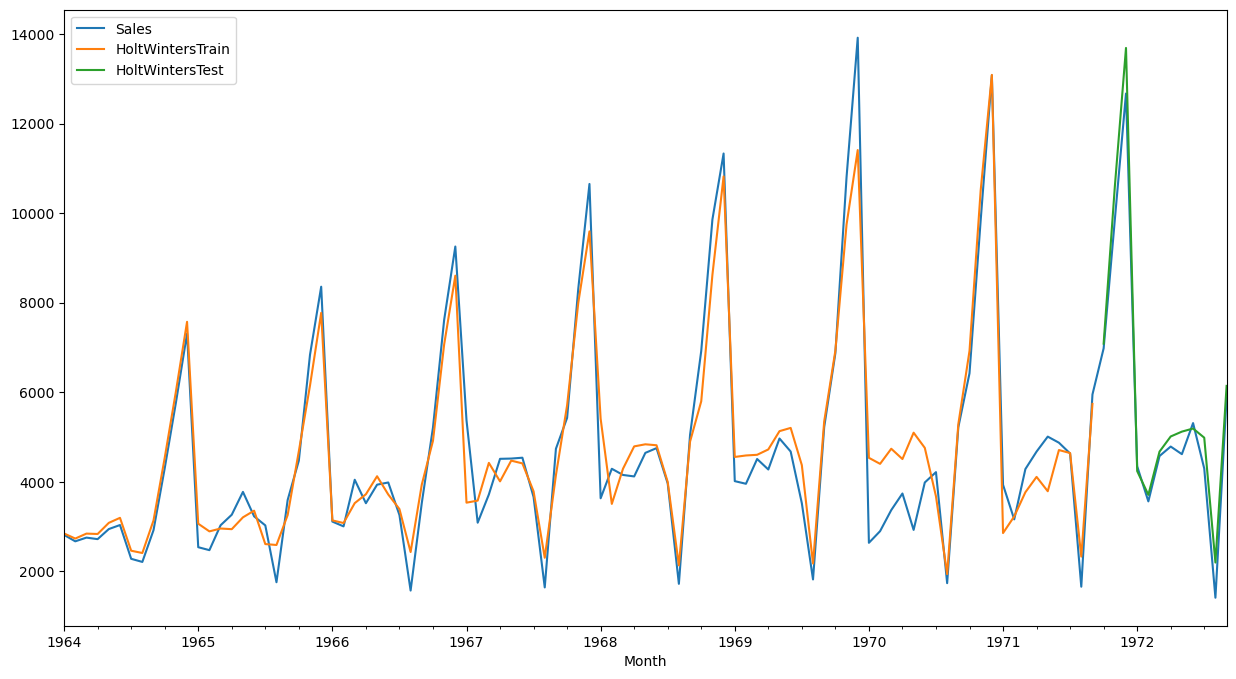

In [90]:
df.index.freq = 'MS'

Ntest  = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

### boolean series to index df row
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

hw = ExponentialSmoothing(
       train['Sales'],
       initialization_method = 'legacy-heuristic',
       trend ='add' , seasonal ='add' , seasonal_periods=12
)
res_hw = hw.fit()

df.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues
df.loc[test_idx , 'HoltWintersTest'] = res_hw.forecast(Ntest)
df[['Sales','HoltWintersTrain','HoltWintersTest']].plot(figsize=(15,8))





In [93]:
print(r2_score(train['Sales'],res_hw.fittedvalues))
print(r2_score(test['Sales'], res_hw.forecast(Ntest)))

0.917000318394892
0.9681195188482947


In [ ]:
#######################  stock prices   ###########################

<Axes: xlabel='Date'>

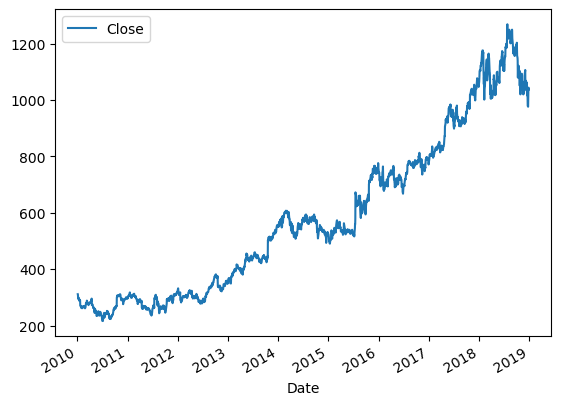

In [106]:
df = pd.read_csv("../Datasets/sp500sub (1).csv" , index_col='Date',parse_dates=True)
goog = df[df['Name']=='GOOG'][['Close']].copy()
goog.plot()

<Axes: xlabel='Date'>

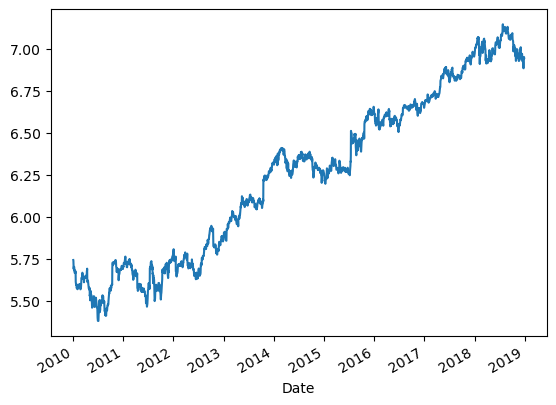

In [111]:
goog['LogClose'] = np.log(goog['Close'])
goog['LogClose'].plot()


In [112]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]


##### boolean series to index df rows
train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]


hw = ExponentialSmoothing(
       train['LogClose'],
       initialization_method = 'legacy-heuristic',
       trend='add',seasonal=None
)
res_hw = hw.fit()


goog.loc[train_idx, 'HoltwintersTrain'] = res_hw.fittedvalues
goog.loc[test_idx, 'HoltwintersTest'] = res_hw.forecast(Ntest).to_numpy()


c:\Users\Tharindu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Tharindu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Tharindu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date'>

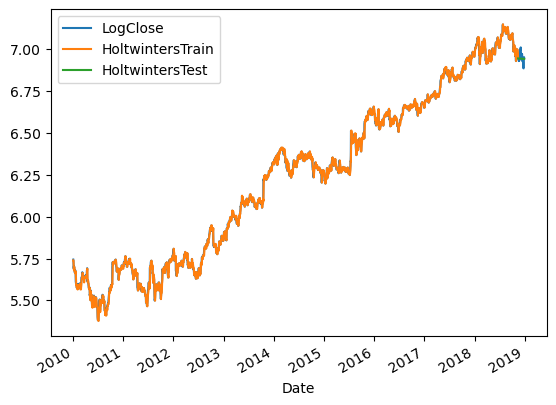

In [114]:
goog[['LogClose','HoltwintersTrain','HoltwintersTest']].plot()